In [8]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "data_10.json"


def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates RNN-LSTM model
    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 130, 64)           19968     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________
Train on 5997 samples, validate on 1500 samples
Epoch 1/30
5997/5997 [==============================] - 10s 2ms/samp

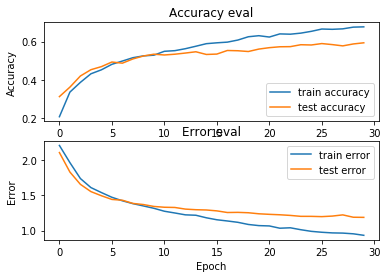

2499/2499 - 1s - loss: 1.1439 - accuracy: 0.6146

Test accuracy: 0.61464584


In [9]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [11]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [17]:
X=X_test[90]
y=y_test[90 ]
predict(model,X,y)

Target: 9, Predicted label: [5]
